## Assignment 1 - Hand Written Digit Recognition

### A. Tasks
Answers to the tasks should be entered into the appropriate sub-section inside the section ```C. Answers``` found towards the end of this notebook

For some of the tasks, you may be asked to change the code directly inside the section ```B.Code```. For these tasks, describe the changes you made to the code in their appropriate sub-section inside the section ```C. Answers```

1. Review the code and write a summary explaining what each of the sub-sections ```B1``` to ```B11``` performs.



2. Change the number of hidden neurons in sub-section ```B.4``` and run the complete notebook. You need to run the notebook nine times and for each run change the number of hidden neurons to one of these values ```20, 40, 60, 80, 100, 120, 140, 180, 200```. Record the test MAPE after each run. Explain your observation on how increasing or decreasing the number of hidden neurons impact the test error.



3. How does increasing or decreasing the learning rate (lr) from sub-section ```B.6``` affect the training process. You may change the learning rate value ```0.9, 0.1, 0.01, 0.001, 0.0001``` and describe your observations



4. **[Optional | Advanced]** If we want to insert another hidden layer, we need to change sub-section ```B.3```, ```B.4```, ```B.5```, ```B.9``` and ```B.10```
    - Can you comment on what needs to be changed to have another hidden layer
    - Can you implement the changes so that the network will have two hidden layers

### B. Code

In [31]:
import numpy as np
from matplotlib import pyplot as plt

import torch

# TorchVision provides a lot of sample dataset. 
# We are interested in the MNIST dataset
# The dataset comprises of pixel data for different handwritten
# digits and a text label describing the same
from torchvision.datasets import MNIST

#### B.1 Preping the dataset

In [32]:
# Toggle the download value to True, if the dataset is not locally available
mnist_data = MNIST('MNIST', train=True, download=True)
# mnist_data.data contains the pixel imformation for 60000 images
# mnist_data.targets contain the text label for the 60000 images
print('shape of the dataset: {}, and its label: {}'.format(mnist_data.data.shape, mnist_data.targets.shape))

shape of the dataset: torch.Size([60000, 28, 28]), and its label: torch.Size([60000])


#### B.2 Visualizing the dataset

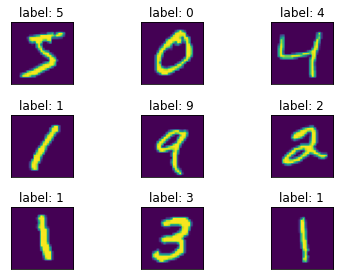

In [33]:
# We will visualize nine randomly choosen images
indices = np.random.choice(len(mnist_data.data), size=9)

fig, axs = plt.subplots(3 ,3)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(mnist_data.data[i])
    ax.set_title('label: {}'.format(mnist_data.targets[i]))
    # Removes x and y axis labels and ticks
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

fig.tight_layout()



In [34]:
# Specifying the layers of the ann. 
# This network will have
# l1: Input -> Hidden
# l2: Hidden -> Output
def nn(x, w1, w2):
    # Dot product can also be calculated using the operator symbol @
    l1 = x @ w1
    
    # We use the RELU activation function rather than Sigmoid. 
    # Recent research shows RELU outperforming Sigmoid in many cases. In purticular addressing the issue of vanishing gradient
    # More about RELU: https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning/notebook
    l1 = torch.relu(l1)
    l2 = l1 @ w2

    return l2
    


#### B.4 Neuron per layer

In [35]:
# Specify the number of neurons in each layer: Input, Hidden1, Hidden2, Output
# We can observe from the shape of the dataset that each image has the pixel information represented as a 28x28 matrix
# We can flatten it and feed each pixel to a neuron. Therefore, the number of neurons in the input layer will be 28 * 28 - 784
inNeurons = 784

# There are not explicit formula to determine the number of neurons in the hidden layers
# The optimal number of neurons for the hidden layers can be identified by trail and error
# In this case we arbitrarily choose the set the the following number of neurons for the hidden layers
hNeurons = 120

# The number of unique labels for this dataset will be 0 to 1 or 10 unique labels since it recognizes handwritten digits
# We can extract that from the targets as well
outNeurons = len(mnist_data.targets.unique())


#### B.5 Generating random weights

In [36]:
# initialize the random seed for torch
torch.seed = 42

# Randomly generate the weights. Set requires_grad True for all
w1 = torch.randn(inNeurons, hNeurons, requires_grad=True)
w2 = torch.randn(hNeurons, outNeurons, requires_grad=True)

print('shape of w1: {}, w2: {}'.format(w1.shape, w2.shape))

shape of w1: torch.Size([784, 120]), w2: torch.Size([120, 10])


#### B.6 Hyperparameter tuning

In [37]:
# Specify the learning rate
lr = 0.001
# Number of times we want to pass through the dataset through the network
epochs = 2000
# During each pass through, we will randomly select a subset of data. The size of the subset is specified
batch_size = 100

#### B.7 Loss and Optimization Functions

In [38]:
# We specify our loss and optimization functions.
# For this case, we use CrossEntropyLoss as the loss function as it suits classification problems. More can be read at: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
lossfn = torch.nn.CrossEntropyLoss()
# For optimizer we choose ADAM, as adam showes better results than SGD. More can be read at: https://arxiv.org/abs/1412.6980
optim = torch.optim.Adam(params=[w1, w2], lr=lr)

#### B.8 Train Test Split

In [39]:
# We will split the dataset into two: Train set and Test Set
# Train set will contain 80% of the original data set along with their corresponding targets
# The remaining 20% will be choosen as the Test Set

# We will perform the train-test split by randomly choosing 80% of non-repeating indices from the data set and placing then into trainIndices
n = len(mnist_data.data)
trainIndices = np.random.choice(n, size=int(np.round(.8 * n)), replace=False)
# All other indices not present in the trainIndices will be placed into testIndices
testIndices = np.setdiff1d(np.arange(n), trainIndices)
print('total number of records in the dataset {}. {} records were choosen for the train set and {} records for the test set equalling to {}'.format(
    n, len(trainIndices), len(testIndices), len(trainIndices) + len(testIndices)
))

total number of records in the dataset 60000. 48000 records were choosen for the train set and 12000 records for the test set equalling to 60000


#### B.9 Train the model

In [40]:
# We pass the specified batch size of records through the network and perform back propogation at each itteration
for e in range(epochs):
    # Choose the records for the batch from the trainIndices
    rid = np.random.choice(trainIndices, size=batch_size)
    # We retrieve the pixel data and for these record indices and flatten the 28x28 image into a vector of size 784 
    x = mnist_data.data[rid].float().flatten(start_dim=1)
    # Normalize the vector to be between 0 and 1
    x = x / x.max()
    # Make a prediction using the neural network
    pred = nn(x, w1, w2)
    # Get the ground truth image labels
    target = mnist_data.targets[rid]
    # Compute the loss
    loss = lossfn(pred, target)
    # Perform backpropogation
    loss.backward()
    # Update the params
    optim.step()
    # Reset the gradients after updating the params
    optim.zero_grad()

    # Print the progress
    if e % np.round(epochs/10) == 0:        
        print('epoch: {:d}, error: {:.2f}'.format(e, loss))

epoch: 0, error: 110.50
epoch: 200, error: 11.26
epoch: 400, error: 4.90
epoch: 600, error: 4.91
epoch: 800, error: 4.76
epoch: 1000, error: 4.25
epoch: 1200, error: 5.99
epoch: 1400, error: 2.56
epoch: 1600, error: 3.64
epoch: 1800, error: 1.39


#### B.10 Test the model on unseen or the test dataset

In [41]:
# We choose the records as per the test indices
x = mnist_data.data[testIndices].float().flatten(start_dim=1)
# Pass them through the network to get the predictions
pred = nn(x, w1, w2)
# The predicted values is a matric with the rows representing total number of records and 
# columns the weights for the each unique class
# For the vector of weights for each row, we will use np.argmax to find out the index which has the max weight
# That index will be choosen as the predicted label for the row
predLabels = pred.argmax(axis=1)

# Get the test dataset actual values
target = mnist_data.targets[testIndices]

# We will use Mean Absolute Percentage Error (MAPE) to report on the test error
# You may read about MAPE here: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
_predlabel = predLabels + 1 # Offset the 0 label
_target = target + 1 # Offset the 0 label
print('error: {} %'.format( torch.mean(torch.abs((_target - _predlabel) / _target)) * 100 ))
_predlabel = _predlabel - 1 # Undo the offset change


error: 10.687679290771484 %


#### B.11 Visualizing the test dataset
##### Compare the actual and predicted values

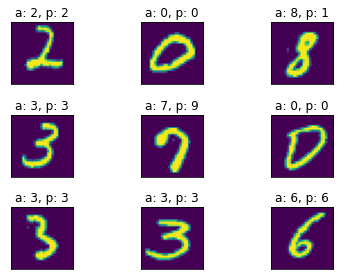

In [13]:
import random

# We will visualize nine randomly choosen images
# We choose 9 images from the test dataset and their corresponding index for the predicted dataset
# indices will capture the predictedIndex and testIndex to choose as [(predictedIndex, testIndex), ...]
indices = [random.choice(list(enumerate(testIndices))) for _ in range(9)]

fig, axs = plt.subplots(3 ,3)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(mnist_data.data[indices[i][1]])
    ax.set_title('a: {}, p: {}'.format(mnist_data.targets[indices[i][1]], _predlabel[indices[i][0]]))
    # Removes x and y axis labels and ticks
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

fig.tight_layout()



### C. Answers

#### C.1 Task 1
------------
B.1: 
You load the dataset. As you have set download to False, you must have it locally on your computer.

B.2: 
You say you visualize 9 random images. But in fact the nine random indices are never used. So you are actually just visualizing the same 9 images each time. 

B.3: 
You define the two-layered NN consisting of an input layer, hidden layer and an output layer.

The function has three parameters: 
- x is the input vector
- w1 is the weights of the first layer
- w2 is the weights of the second layer

First you apply a linear transformation to the input by doing a dot product: x @ w1. Then you pass the result through an activation function (ReLU). Then you do another linear transformation by calculating the dot product of l1 and w2. 

B.4: 
- You set the numbers of numbers of input neurons (28x28)=784
- You set the number of hidden neurons, 124
- You set the number of output neurons, 10

B.5:
- You set a random seed so that randomly generated values can be recreated
- Then you initialize the weights of of the two hidden layers
- You set requires_grad = True, meaning a gradients will be calculated

B.6:
- You set learning rate; this hyperparameter decides in what degree the weights and biases should be adjusted to the gradients
- epochs; usually determines how many passes will be made through the dataset.
- batch size; determines how many samples should be sent through forward before grads are calculated

B.7:
- Loss fn. is set to cross entropy
- Optimizer is set to ADAM

B.8:
- Data is split into train and test.
- You assign 80 % of the data as training data. What data is assigned to the training set is random.
- The remaining 20 % is assigned to the test set. 

B.9:
- You train the network.
- You select batch_size number of random samples from the training set and predict their label.
- You normalize the data and flatten the matrix from 28x28 -> 784.
- Then you get their true label and calculate loss. 
- Then you adjust the weights and set the gradients to zero. 

B.10:
- You evaluate the network on the entire test dataset.
- You pass the test dataset through the NN and get a matrix with predictions. Each row is a sample and in each column you have a numerical value. If the biggest value is in column 0, then label 0 is predicted for the sample. This is done by the argmax function. 
- Then you get the true label of each sample and calculate Mean Absolute Percentage Error (MAPE). 

B.11:
- You visualize 9 randomly selected handwritten digits and their predictions. 
- We can see that the NN does a fairly good job of predicting the label of the images. 


#### C.2 Task 2
------------

num_hidden_neurons = [20, 40, 60, 80, 100, 120, 140, 180, 200]


In [26]:
num_hidden_neurons = [20, 40, 60, 80, 100, 120, 140, 180, 200]
x_test = mnist_data.data[testIndices].float().flatten(start_dim=1)


for num_hidden in num_hidden_neurons:
    print(f"Training network with number of hidden neurons = {num_hidden}")
    w1 = torch.randn(inNeurons, num_hidden, requires_grad=True)
    w2 = torch.randn(num_hidden, outNeurons, requires_grad=True)
    
    lossfn = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(params=[w1, w2], lr=lr)

    # We pass the specified batch size of records through the network and perform back propogation at each itteration
    for e in range(epochs):
        # Choose the records for the batch from the trainIndices
        rid = np.random.choice(trainIndices, size=batch_size)
        # We retrieve the pixel data and for these record indices and flatten the 28x28 image into a vector of size 784 
        x = mnist_data.data[rid].float().flatten(start_dim=1)
        # Normalize the vector to be between 0 and 1
        x = x / x.max()
        # Make a prediction using the neural network
        pred = nn(x, w1, w2)
        # Get the ground truth image labels
        target = mnist_data.targets[rid]
        # Compute the loss
        loss = lossfn(pred, target)
        # Perform backpropogation
        loss.backward()
        # Update the params
        optim.step()
        # Reset the gradients after updating the params
        optim.zero_grad()

        # Print the progress
        if e % np.round(epochs/10) == 0:        
            print('epoch: {:d}, error: {:.2f}'.format(e, loss))
            

    pred_test = nn(x_test, w1, w2)
    predLabels = pred_test.argmax(axis=1)
    target = mnist_data.targets[testIndices]
    
    _predlabel = predLabels + 1 # Offset the 0 label
    _target = target + 1 # Offset the 0 label
    print('error: {} %'.format( torch.mean(torch.abs((_target - _predlabel) / _target)) * 100 ))
    print("---------------------------------------------------------------------------------")

Training network with number of hidden neurons = 20
epoch: 0, error: 34.94
epoch: 200, error: 6.51
epoch: 400, error: 3.16
epoch: 600, error: 2.20
epoch: 800, error: 2.08
epoch: 1000, error: 2.01
epoch: 1200, error: 1.83
epoch: 1400, error: 1.84
epoch: 1600, error: 2.03
epoch: 1800, error: 1.68
error: 44.77924728393555 %
---------------------------------------------------------------------------------
Training network with number of hidden neurons = 40
epoch: 0, error: 60.77
epoch: 200, error: 8.02
epoch: 400, error: 6.31
epoch: 600, error: 2.63
epoch: 800, error: 3.33
epoch: 1000, error: 1.94
epoch: 1200, error: 2.23
epoch: 1400, error: 1.32
epoch: 1600, error: 2.47
epoch: 1800, error: 1.38
error: 19.73276710510254 %
---------------------------------------------------------------------------------
Training network with number of hidden neurons = 60
epoch: 0, error: 100.06
epoch: 200, error: 10.04
epoch: 400, error: 6.77
epoch: 600, error: 6.53
epoch: 800, error: 4.10
epoch: 1000, erro

Observations: 
- Error falls consistently untill hidden neurons = 200
- Training slows down when we use more neurons

#### C.3 Task 3
------------
Your Answer Here

In [27]:
learning_rates = [0.9, 0.1, 0.01, 0.001, 0.0001]
x_test = mnist_data.data[testIndices].float().flatten(start_dim=1)


for lr in learning_rates:
    print(f"Training network with learning rate = {lr}")
    w1 = torch.randn(inNeurons, hNeurons, requires_grad=True)
    w2 = torch.randn(hNeurons, outNeurons, requires_grad=True)
    
    lossfn = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(params=[w1, w2], lr=lr)

    # We pass the specified batch size of records through the network and perform back propogation at each itteration
    for e in range(epochs):
        # Choose the records for the batch from the trainIndices
        rid = np.random.choice(trainIndices, size=batch_size)
        # We retrieve the pixel data and for these record indices and flatten the 28x28 image into a vector of size 784 
        x = mnist_data.data[rid].float().flatten(start_dim=1)
        # Normalize the vector to be between 0 and 1
        x = x / x.max()
        # Make a prediction using the neural network
        pred = nn(x, w1, w2)
        # Get the ground truth image labels
        target = mnist_data.targets[rid]
        # Compute the loss
        loss = lossfn(pred, target)
        # Perform backpropogation
        loss.backward()
        # Update the params
        optim.step()
        # Reset the gradients after updating the params
        optim.zero_grad()

        # Print the progress
        if e % np.round(epochs/10) == 0:        
            print('epoch: {:d}, error: {:.2f}'.format(e, loss))
            

    pred_test = nn(x_test, w1, w2)
    predLabels = pred_test.argmax(axis=1)
    target = mnist_data.targets[testIndices]
    
    _predlabel = predLabels + 1 # Offset the 0 label
    _target = target + 1 # Offset the 0 label
    print('error: {} %'.format( torch.mean(torch.abs((_target - _predlabel) / _target)) * 100 ))
    print("---------------------------------------------------------------------------------")

Training network with learning rate = 0.9
epoch: 0, error: 106.11
epoch: 200, error: 2.30
epoch: 400, error: 2.30
epoch: 600, error: 2.30
epoch: 800, error: 2.30
epoch: 1000, error: 2.30
epoch: 1200, error: 2.30
epoch: 1400, error: 2.30
epoch: 1600, error: 2.30
epoch: 1800, error: 2.30
error: 70.50946044921875 %
---------------------------------------------------------------------------------
Training network with learning rate = 0.1
epoch: 0, error: 142.12
epoch: 200, error: 0.55
epoch: 400, error: 0.32
epoch: 600, error: 0.50
epoch: 800, error: 0.38
epoch: 1000, error: 0.42
epoch: 1200, error: 0.39
epoch: 1400, error: 0.31
epoch: 1600, error: 0.22
epoch: 1800, error: 0.56
error: 8.118552207946777 %
---------------------------------------------------------------------------------
Training network with learning rate = 0.01
epoch: 0, error: 92.65
epoch: 200, error: 2.35
epoch: 400, error: 1.18
epoch: 600, error: 0.01
epoch: 800, error: 0.69
epoch: 1000, error: 0.63
epoch: 1200, error: 0

#### C.4 Task 4
------------
Your Answer Here

4.1 
To have another hidden layer we need to change the following:

- In B.3 we need to add one linear transformation to the nn-function, let's call it w3. W3 also has to be a parameter for the function. We should also send this linear transformation through an activation function, in this case ReLU. 

- In B.5 we need to initiate one more tensor with weights, W3. It's important to set requires_grad = True. We have to make sure the dimension are correct between the two hidden layers and the output layer.

- In B.7 we have to update the list of params in the optimizer (ADAM) with W3. 

- In B.9 we have to make sure the function call is updated with W3. The same goes for B.10.

In [44]:
def nn_2hidden(x, w1, w2, w3):
    l1 = x @ w1
    l1 = torch.relu(l1)
    
    l2 = l1 @ w2 
    l2 = torch.relu(l2)
    
    l3 = l2 @ w3
    return l3

In [45]:
torch.seed = 42

w1 = torch.randn(inNeurons, hNeurons, requires_grad=True)
w2 = torch.randn(hNeurons, hNeurons, requires_grad=True)
w3 = torch.randn(hNeurons, outNeurons, requires_grad=True)

In [46]:
optim = torch.optim.Adam(params=[w1, w2, w3], lr=lr)

In [47]:
for e in range(epochs):
    rid = np.random.choice(trainIndices, size=batch_size)
    
    x = mnist_data.data[rid].float().flatten(start_dim=1)
    x = x / x.max()
    
    pred = nn_2hidden(x, w1, w2, w3)
    target = mnist_data.targets[rid]
    
    loss = lossfn(pred, target)
    loss.backward()
    
    optim.step()
    optim.zero_grad()

    if e % np.round(epochs/10) == 0:        
        print('epoch: {:d}, error: {:.2f}'.format(e, loss))

epoch: 0, error: 657.24
epoch: 200, error: 64.46
epoch: 400, error: 28.51
epoch: 600, error: 30.01
epoch: 800, error: 26.58
epoch: 1000, error: 28.83
epoch: 1200, error: 25.25
epoch: 1400, error: 11.11
epoch: 1600, error: 9.71
epoch: 1800, error: 6.80


In [48]:
x = mnist_data.data[testIndices].float().flatten(start_dim=1)

pred = nn_2hidden(x, w1, w2, w3)
predLabels = pred.argmax(axis=1)

target = mnist_data.targets[testIndices]

_predlabel = predLabels + 1 # Offset the 0 label
_target = target + 1 # Offset the 0 label
print('error: {} %'.format( torch.mean(torch.abs((_target - _predlabel) / _target)) * 100 ))
_predlabel = _predlabel - 1 # Undo the offset change

error: 10.12952709197998 %
